## Part 1 of Toronto neighborhood new business opportunities

## Introduction
The purpose of this study is to use a recommender system to suggest new business opportunities for Toronto neighborhoods that currently have few venues (<20 venues, "sparse neighborhoods"). The study proposes to use a user-based collaborative filtering mechanism where the neighborhoods (defined by postal codes) are the "users", and the frequency of various kind of venues are the "scores" of the venues in each neighborhood. Based on similarity among various neighborhoods, this study seeks to recommend venues that should be characteristic of but currently absent from sparse neighborhoods.

This is the part one of the project. For part 2, see: [Toronto_neighborhood_new_biz_rec](https://github.com/chencheng23/Toronto/blob/master/Toronto_neighborhood_new_biz_rec.ipynb).

This part deals with data acquisition, cleaning up, and clustering using K-means based on frequency of venue types. Specific steps include:
1. <a href=#scrape>Scraping Toronto neighborhood data from</a> [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
2. <a href=#group>Grouping the data by postal codes </a>
3. <a href=#4square>Obtaining venues in each postal code area from Foursquare </a>
4. <a href=#cluster>One-hot encoding the venue categories, and clustering using K-means clustering </a>
5. <a href=#visualize>Visualizing the clustering results </a>

In [1]:
import pandas as pd
import numpy as np

<a name="scrape" /> 
### Scraping Toronto neighborhood data from Wikipedia

In [16]:
#using the pd.read_html to scrape the wiki page. Upon inspection of the result, the first element is the desired table.
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header = 0)
df = df[0]

#rename 'Neighbourhood' to 'Neighborhood', because 'Murica... lol
df.rename(columns = {'Neighbourhood': 'Neighborhood', 'Postcode':'Postal Code'}, inplace=True)

In [17]:
# assigning 'Not assigned' neighborhoods with the names of the Borough
for index, row in df.iterrows():
    if row[2] == 'Not assigned':
        row[2] = row[1]
    else:
        pass

In [18]:
#drop the rows containing 'Not assigned'
df.replace('Not assigned', np.nan, inplace=True)
df.dropna(axis = 0, inplace=True)

In [20]:
df.sort_values(by = 'Postal Code').head()

,Postal Code,Borough,Neighborhood
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern
29,M1C,Scarborough,Port Union
28,M1C,Scarborough,Rouge Hill
27,M1C,Scarborough,Highland Creek


In [21]:
df.describe()

,Postal Code,Borough,Neighborhood
count,211,211,211
unique,103,11,209
top,M8Y,Etobicoke,St. James Town
freq,8,45,2


In [24]:
#combine the neighborhoods with the same postcode
df = df.groupby(by = ['Postal Code', 'Borough'])['Neighborhood'].apply(lambda x: ', '.join(x.astype(str))).reset_index()

<a name='group' /> 
### Grouping the data by postal codes

In [201]:
df.head(10)

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [26]:
df.shape

(103, 3)

In [10]:
#To get the longitudes and latitudes of each Postcode

import geocoder # import geocoder. Ended up having to manually install from github (https://github.com/DenisCarriere/geocoder)

def get_coordinate(postal_code):
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
      lat_lng_coords = g.latlng

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude, longitude

In [ ]:
for index, row in df.iterrows():
    latitude, longitude = get_coordinate(row[0])
    df['Latitude'] = latitude
    df['Longitude'] = longitude
    
#tried this, but could not fetch the data

In [200]:
#tried this on a single postcode, still could not finish..
# get_coordinate('M5G')


In [33]:
#get data from the geospatial_coordinates file provided
df_coord = pd.read_csv('Toronto_Geospatial_Coordinates.csv')
df_coord.head()
df_coord.shape

(103, 3)

In [34]:
#merge the coordinates dataframe with the previous dataframe
df_merge = pd.merge(df, df_coord, on = 'Postal Code')

In [44]:
df_merge.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [102]:
df_merge.shape

(103, 5)

In [194]:
#explore the neigborhood using Foursquare API and plotting using folium

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [37]:
import folium

In [39]:
from geopy.geocoders import Nominatim

In [63]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [171]:
# get coordinates for Downtown Toronto

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Downtown Toronto are 43.653963, -79.387207.


In [57]:
# getting a list of unique Borough name

Boroughs = df_merge['Borough'].unique()
Boroughs

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       "Queen's Park", 'Mississauga', 'Etobicoke'], dtype=object)

In [59]:
#using Foursquare to get venues in each Postal Code area

CLIENT_ID = '---' # your Foursquare ID
CLIENT_SECRET = '---' # your Foursquare Secret
VERSION = '20190722' # Foursquare API version

LIMIT = 100

In [60]:
def getNearbyVenues(postcode, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(postcode, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<a name='4square' /> 
### Obtaining venues in each postal code area from Foursquare

In [64]:
toronto_venues = getNearbyVenues(df_merge['Postal Code'], df_merge['Latitude'], df_merge['Longitude'])
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,M1C,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,M1C,43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
3,M1E,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,M1E,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [177]:
print(toronto_venues.shape)

(2251, 7)


In [180]:
toronto_venues.to_csv('toronto_venues.csv')

#### Use a histogram to visualize the distribution of venues among postal code areas

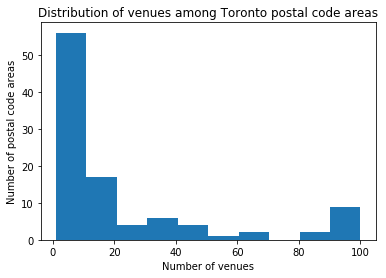

In [199]:
toronto_venues.groupby(by = 'Neighborhood').count()['Venue Category'].hist()
plt.title('Distribution of venues among Toronto postal code areas')
plt.xlabel('Number of venues')
plt.ylabel('Number of postal code areas')
plt.grid(b=None)
plt.show()

<a name='cluster' /> 
### One-hot encoding the venue categories, and clustering using K-means clustering

In [86]:
#convert venue category to onehot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
# toronto_onehot.head()
toronto_onehot['Postal Code'] = toronto_venues['Neighborhood']
#move 'Postal Code' column to the front
toronto_onehot = toronto_onehot[[toronto_onehot.columns[-1]] + list(toronto_onehot.columns[0:-1])]
toronto_onehot.head()

,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
toronto_onehot.shape

(2251, 280)

In [202]:
# save to csv file for part 2 of the project
toronto_onehot.to_csv('toronto_onehot.csv')

In [115]:
#calculate the mean/frequency of each venue category grouped by Postal Code
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(101, 280)


,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
#Using K-means clustering
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Postal Code', axis = 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
print(kmeans.labels_.shape)
toronto_grouped['Cluster'] = ''
toronto_grouped['Cluster'] = kmeans.labels_

toronto_new = df_merge.copy()
toronto_new = pd.merge(toronto_grouped, toronto_new, on='Postal Code')

(101,)


<a name='visualize' /> 
### Visualizing the clustering results

In [173]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_new['Latitude'], toronto_new['Longitude'], toronto_new['Postal Code'], toronto_new['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Adding a image of the map because folium won't render once uploaded to github
<img src="files/toronto_clustering.jpg">

### take only Postal Code areas with >20 venues and re-do the clustering

In [183]:
toronto_venues_filtered = toronto_venues.copy()
toronto_venues_count = toronto_venues.groupby(by = 'Neighborhood').count().reset_index()
toronto_venues_count = toronto_venues_count[toronto_venues_count['Venue'] >= 20]

toronto_venues_filtered = toronto_venues_filtered[toronto_venues_filtered['Neighborhood'].isin(toronto_venues_count['Neighborhood'])]
toronto_venues_filtered.shape

(1788, 7)

In [184]:
#convert venue category to onehot encoding
toronto_onehot_filtered = pd.get_dummies(toronto_venues_filtered[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot_filtered['Postal Code'] = toronto_venues_filtered['Neighborhood']
#move 'Postal Code' column to the front
toronto_onehot_filtered = toronto_onehot_filtered[[toronto_onehot_filtered.columns[-1]] + list(toronto_onehot_filtered.columns[0:-1])]
toronto_onehot_filtered.head()

,Postal Code,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
94,M2J,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,M2J,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,M2J,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,M2J,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,M2J,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
toronto_grouped_filtered = toronto_onehot_filtered.groupby('Postal Code').mean().reset_index()
print(toronto_grouped_filtered.shape)
toronto_grouped_filtered.head()

(31, 225)


,Postal Code,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M2J,0.0,0.016393,0.0,0.0,0.0,0.0,0.000000,0.016393,0.0,...,0.00000,0.0,0.0,0.016393,0.000000,0.0,0.0,0.016393,0.032787,0.00000
1,M2N,0.0,0.000000,0.0,0.0,0.0,0.0,0.027027,0.000000,0.0,...,0.00000,0.0,0.0,0.000000,0.027027,0.0,0.0,0.000000,0.000000,0.00000
2,M3C,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.050000,0.0,...,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000
3,M4G,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000
4,M4K,0.0,0.023810,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.02381,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.02381


In [186]:
#Using K-means clustering
kclusters = 5

toronto_grouped_clustering_filtered = toronto_grouped_filtered.drop('Postal Code', axis = 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering_filtered)
print(kmeans.labels_.shape)
toronto_grouped_filtered['Cluster'] = ''
toronto_grouped_filtered['Cluster'] = kmeans.labels_

toronto_new_filtered = df_merge.copy()
toronto_new_filtered = pd.merge(toronto_grouped_filtered, toronto_new_filtered, on='Postal Code')

(31,)


In [190]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_new_filtered['Latitude'], toronto_new_filtered['Longitude'], \
                                  toronto_new_filtered['Postal Code'], toronto_new_filtered['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Adding a image of the map because folium won't render once uploaded to github
<img src="files/toronto_clustering_20_or_more.jpg">

### Comments 

Comparing this map to the previous map (including all postal codes), most areas with high venue density are around downtown Toronto. In addition, the clustering didn't change much. Most areas fall into one cluster. 

For the all-inclusive map, the peripheral postal codes fall into same cluster as those in downtown Toronto, which is somewhat surprising, given that it was assumed that downtown areas should have a different set of venue types than the suburbs.
